In [1]:
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns

from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud

In [2]:
okt = Okt()

## CSV 파일로 변환

#### 질문-답변 세트는 각각 두번의 줄 띄어쓰기(\n\n)으로 구별되어 있음. 단 질문과 답변을 구별할 수 있는 특별한 기호가 없어서 모든 답변 앞에 특수문자 '▶'를 삽입함

In [4]:
text = """
135. 부모님 이야기를 들으면 저항할 힘도 없어요. 눈물만 나요.
▶부모님의 이야기를 들으면 저항할 힘도 없이 슬퍼서 눈물만 나시는군요. 우울증으로 인해 무기력하여 저항하는 에너지도 없어 힘들 수 있어요.
"""

In [5]:
text2 = re.sub(" +", " ", text)   #하나 이상의 공백은 모두 한 번의 공백으로 교체

In [6]:
text2 = text2.replace("\n\n", "▶").replace("\n \n", "▶").replace("\n", "")  #질문-답변 묶음을 구별하는 \n\n 과 \n \n을 ▶로 처리하여 이후에 문장을 구분할 때 특수기호 '▶'를 사용하여 모든 질문과 답변이 각각 따로 분리되도록 처리함

In [7]:
text2

'1. 약을 먹고 나서부터 잠이 계속 와요. 억지로 안 자려고 해야 할까요?▶약을 먹고 나서 잠을 많이 자는 증상이 있으시군요. 억지로 안 자려고 하는 것 보다는 자신에게 맞는 자연스럽고 규칙적인 수면습관을 만드는 것이 좋습니다. 짧은 시간 안에 자고 깨는 것은 좋지 않으므로 한 번에 일어나거나 아예 자는 것이 더 좋습니다.▶2. 이전보다 상태가 더 나빠졌는데, 이게 약물 부작용인지 혹은 우울증이 더 나빠진 건지 어떻게 알죠?▶어떤 부분에서 이전보다 상태가 나빠졌다고 느끼시나요? 우울증 약물 부작용은 초기에 나타날 수 있고 적응이 되면 사라질 수 있습니다. 우울증이 더 나빠진 것 같다면 전문가와 상담, 치료를 받아보세요. ▶3. 약 안 먹고 상담만 받고 싶어요. 약 복용 말고 상담 치료를 받고 싶은데, 어디로 가면 되나요?▶심리 상담 센터에서 약 복용 없이 상담만 받아보실 수 있습니다. ▶4. 심리치료를 받으면 도움이 되나요? or 상담을 받으면 정말 나아질 수 있을까요?▶우울증은 편안하고 깊이 있는 대화를 통해 우울한 마음을 회복할 수 있습니다. 전문가와 상담을 통해 삶을 지속적으로 편안하게 유지할 수 있도록 도움을 받을 수 있습니다.▶5. 인지행동 치료는 뭔가요? 우울증에는 인지행동 치료만 효과가 있나요? ▶잘못된 인지, 행동을 교정해주는 인지행동치료는 심리적 경험을 탐색하고 치료를 위한 활동 계획을 수립하여 스스로 실행하고 연습할 수 있도록 교육과 과제를 통해 효과를 볼 수 있습니다. 우울증에는 다양한 치료가 있으며 인지행동 치료만 효과가 있는 것은 아닙니다.▶6. (n개월 정도 치료를 받은 후) 이 정도 진료/상담 받았으면 나아져야 하는 거 아닌가요? or 이 정도 약을 먹었으면 나아져야 하는 거 아닌가요?▶그동안 진료/상담을 받느라 고생하셨네요. 짧은 시간이 아닌데도 불구하고 열심히 치료를 하신 것에 칭찬해드리고 싶어요. 그러나 우울증은 사람마다 차이가 날 수 있으며, 치료 기간이 정해져 있지 않습니다. 지속적으로 꾸준히 치료하는 것이 중요합니다. 조

In [8]:
ques_answer_list = text2.split("▶")   #특수문자 '▶'로 텍스트 분리하면 질문과 답변이 따로 분리됨

In [9]:
ques_answer_list   #질문과 답변이 순서대로 저장되어 있는 리스트

['1. 약을 먹고 나서부터 잠이 계속 와요. 억지로 안 자려고 해야 할까요?',
 '약을 먹고 나서 잠을 많이 자는 증상이 있으시군요. 억지로 안 자려고 하는 것 보다는 자신에게 맞는 자연스럽고 규칙적인 수면습관을 만드는 것이 좋습니다. 짧은 시간 안에 자고 깨는 것은 좋지 않으므로 한 번에 일어나거나 아예 자는 것이 더 좋습니다.',
 '2. 이전보다 상태가 더 나빠졌는데, 이게 약물 부작용인지 혹은 우울증이 더 나빠진 건지 어떻게 알죠?',
 '어떤 부분에서 이전보다 상태가 나빠졌다고 느끼시나요? 우울증 약물 부작용은 초기에 나타날 수 있고 적응이 되면 사라질 수 있습니다. 우울증이 더 나빠진 것 같다면 전문가와 상담, 치료를 받아보세요. ',
 '3. 약 안 먹고 상담만 받고 싶어요. 약 복용 말고 상담 치료를 받고 싶은데, 어디로 가면 되나요?',
 '심리 상담 센터에서 약 복용 없이 상담만 받아보실 수 있습니다. ',
 '4. 심리치료를 받으면 도움이 되나요? or 상담을 받으면 정말 나아질 수 있을까요?',
 '우울증은 편안하고 깊이 있는 대화를 통해 우울한 마음을 회복할 수 있습니다. 전문가와 상담을 통해 삶을 지속적으로 편안하게 유지할 수 있도록 도움을 받을 수 있습니다.',
 '5. 인지행동 치료는 뭔가요? 우울증에는 인지행동 치료만 효과가 있나요? ',
 '잘못된 인지, 행동을 교정해주는 인지행동치료는 심리적 경험을 탐색하고 치료를 위한 활동 계획을 수립하여 스스로 실행하고 연습할 수 있도록 교육과 과제를 통해 효과를 볼 수 있습니다. 우울증에는 다양한 치료가 있으며 인지행동 치료만 효과가 있는 것은 아닙니다.',
 '6. (n개월 정도 치료를 받은 후) 이 정도 진료/상담 받았으면 나아져야 하는 거 아닌가요? or 이 정도 약을 먹었으면 나아져야 하는 거 아닌가요?',
 '그동안 진료/상담을 받느라 고생하셨네요. 짧은 시간이 아닌데도 불구하고 열심히 치료를 하신 것에 칭찬해드리고 싶어요. 그러나 우울증은 사람마다 차이가 날 수 있으며, 치

In [10]:
len(ques_answer_list)

270

In [11]:
question_list = ques_answer_list[0:len(ques_answer_list):2]

In [12]:
question_list   #질문만 추출한 리스트

['1. 약을 먹고 나서부터 잠이 계속 와요. 억지로 안 자려고 해야 할까요?',
 '2. 이전보다 상태가 더 나빠졌는데, 이게 약물 부작용인지 혹은 우울증이 더 나빠진 건지 어떻게 알죠?',
 '3. 약 안 먹고 상담만 받고 싶어요. 약 복용 말고 상담 치료를 받고 싶은데, 어디로 가면 되나요?',
 '4. 심리치료를 받으면 도움이 되나요? or 상담을 받으면 정말 나아질 수 있을까요?',
 '5. 인지행동 치료는 뭔가요? 우울증에는 인지행동 치료만 효과가 있나요? ',
 '6. (n개월 정도 치료를 받은 후) 이 정도 진료/상담 받았으면 나아져야 하는 거 아닌가요? or 이 정도 약을 먹었으면 나아져야 하는 거 아닌가요?',
 '7. 부모님 몰래 진료/상담 받고 싶은데 가능한가요? 부모님께 알리고 싶지 않은데 괜찮나요?',
 '8. 병원에서 입원을 권유했는데 우울증으로 입원 치료를 하기도 하나요?',
 '9. 입원 치료는 무엇인가요?',
 '10. 우울증으로 입원을 하고 싶은데 제가 입원하고 싶다고 하면 입원할 수 있나요? or 집에서는 도저히 나아지지 않을 것 같아 입원해서 치료를 받고 싶은데 가능할까요? ',
 '11. 입원하게 되면 얼마나 입원해야 하나요? ',
 '12. 입원 치료 시 병원은 정말 무서운 곳인가요? 제가 입원해서 치료받아도 되나요? ',
 '13. 입원 치료가 효과가 더 좋나요?',
 '14. 입원 치료 때 여러 사람과 함께 지내는 게 걱정이에요. 그 사람들 때문에 더 힘들어지면 어쩌죠?',
 '15. 우울한데 꼭 밖에 나가고 움직여야만 나아질까요?',
 '16. 산책도 다 귀찮아요. or 산책을 꼭 해야 하나요? or 산책을 안 하면 안 낫나요?',
 '17. 너무 피곤해서 나갈 수가 없어요.',
 '18. 집 밖으로 나가고 싶지 않아요.',
 '19. 밖에도 나가보고 친구들도 만나고 억지로 활동해서 기분을 나아지려고 하는 데 기분이 나아지지 않아요. 기분이 나아지려면 뭘 어떻게 해야 하는 걸까요?',
 '20. 우울할 때 자꾸 사

In [13]:
len(question_list)

135

In [14]:
answer_list = ques_answer_list[1:len(ques_answer_list):2]

In [15]:
answer_list   #답변만 추출한 리스트

['약을 먹고 나서 잠을 많이 자는 증상이 있으시군요. 억지로 안 자려고 하는 것 보다는 자신에게 맞는 자연스럽고 규칙적인 수면습관을 만드는 것이 좋습니다. 짧은 시간 안에 자고 깨는 것은 좋지 않으므로 한 번에 일어나거나 아예 자는 것이 더 좋습니다.',
 '어떤 부분에서 이전보다 상태가 나빠졌다고 느끼시나요? 우울증 약물 부작용은 초기에 나타날 수 있고 적응이 되면 사라질 수 있습니다. 우울증이 더 나빠진 것 같다면 전문가와 상담, 치료를 받아보세요. ',
 '심리 상담 센터에서 약 복용 없이 상담만 받아보실 수 있습니다. ',
 '우울증은 편안하고 깊이 있는 대화를 통해 우울한 마음을 회복할 수 있습니다. 전문가와 상담을 통해 삶을 지속적으로 편안하게 유지할 수 있도록 도움을 받을 수 있습니다.',
 '잘못된 인지, 행동을 교정해주는 인지행동치료는 심리적 경험을 탐색하고 치료를 위한 활동 계획을 수립하여 스스로 실행하고 연습할 수 있도록 교육과 과제를 통해 효과를 볼 수 있습니다. 우울증에는 다양한 치료가 있으며 인지행동 치료만 효과가 있는 것은 아닙니다.',
 '그동안 진료/상담을 받느라 고생하셨네요. 짧은 시간이 아닌데도 불구하고 열심히 치료를 하신 것에 칭찬해드리고 싶어요. 그러나 우울증은 사람마다 차이가 날 수 있으며, 치료 기간이 정해져 있지 않습니다. 지속적으로 꾸준히 치료하는 것이 중요합니다. 조급해하지 마시고 치료를 하시면 좋아질 수 있습니다.',
 '부모님 몰래 진료/상담을 받고 싶은 특별한 이유가 있으신가요? 알리는 것이 싫으시다면 혼자 오셔도 됩니다. 그러나 미성년자인 경우에는 보호자가 필요한 상황이 생길 수도 있습니다.',
 '우울증은 증상의 중증도가 중등도 이상인 경우 입원이 필요합니다. 자살 가능성이 높거나 신체적으로 쇠약한 경우, 정신병적 증상이 동반된 경우, 치료를 지속하거나 치료를 거부하는 경우, 통상적인 치료에 반응하지 않는 경우, 진단적인 접근이 필요할 경우 입원치료가 필요할 수 있습니다.',
 '입원치료는 입원을 하여 

In [16]:
len(answer_list)

135

In [17]:
result = pd.DataFrame({'Interviewer':'이단비', 'Question':question_list, "Answer":answer_list})

In [18]:
result

,Interviewer,Question,Answer
0,이단비,1. 약을 먹고 나서부터 잠이 계속 와요. 억지로 안 자려고 해야 할까요?,약을 먹고 나서 잠을 많이 자는 증상이 있으시군요. 억지로 안 자려고 하는 것 보다...
1,이단비,"2. 이전보다 상태가 더 나빠졌는데, 이게 약물 부작용인지 혹은 우울증이 더 나빠진...",어떤 부분에서 이전보다 상태가 나빠졌다고 느끼시나요? 우울증 약물 부작용은 초기에 ...
2,이단비,"3. 약 안 먹고 상담만 받고 싶어요. 약 복용 말고 상담 치료를 받고 싶은데, 어...",심리 상담 센터에서 약 복용 없이 상담만 받아보실 수 있습니다.
3,이단비,4. 심리치료를 받으면 도움이 되나요? or 상담을 받으면 정말 나아질 수 있을까요?,우울증은 편안하고 깊이 있는 대화를 통해 우울한 마음을 회복할 수 있습니다. 전문가...
4,이단비,5. 인지행동 치료는 뭔가요? 우울증에는 인지행동 치료만 효과가 있나요?,"잘못된 인지, 행동을 교정해주는 인지행동치료는 심리적 경험을 탐색하고 치료를 위한 ..."
...,...,...,...
130,이단비,"131. 엄마가 다 마음대로 하려고 해요, 그만 간섭하면 좋겠어요.",누군가 자신의 일에 간섭을 하고 마음대로 하려고 하면 화가 나기도 하고 힘드시겠네요.
131,이단비,132. 제가 아니라 부모님이 상담을 받았으면 좋겠는데 가능할까요?,부모님이 상담 받았으면 하는 이유가 무엇일까요? 우울증 치료는 본인도 상담 받아야 ...
132,이단비,133. 선생님이 대신 부모님께 제 상태 좀 이야기 해주시면 안 될까요?,본인의 동의하에 부모님께 말씀 드릴 수 있습니다. 그러나 매번 부모님께 자신의 상태...
133,이단비,134. 부모님이 상담에서 무슨 내용을 이야기하는지 궁금해 하시는데 여기에서 있었던...,아닙니다. 타인에게 상담에서의 모든 이야기를 말 할 필요는 없습니다. 자신이 하고 ...


In [19]:
result.to_csv("우울증 질의응답9.csv", index=False, encoding='utf-8-sig')

## 숫자와 기호 제거하기

In [44]:
data = pd.read_csv("./CSV 파일/우울증 질의응답9.csv")

In [45]:
data.head()

,Interviewer,Question,Answer
0,이단비,1. 약을 먹고 나서부터 잠이 계속 와요. 억지로 안 자려고 해야 할까요?,약을 먹고 나서 잠을 많이 자는 증상이 있으시군요. 억지로 안 자려고 하는 것 보다...
1,이단비,"2. 이전보다 상태가 더 나빠졌는데, 이게 약물 부작용인지 혹은 우울증이 더 나빠진...",어떤 부분에서 이전보다 상태가 나빠졌다고 느끼시나요? 우울증 약물 부작용은 초기에 ...
2,이단비,"3. 약 안 먹고 상담만 받고 싶어요. 약 복용 말고 상담 치료를 받고 싶은데, 어...",심리 상담 센터에서 약 복용 없이 상담만 받아보실 수 있습니다.
3,이단비,4. 심리치료를 받으면 도움이 되나요? or 상담을 받으면 정말 나아질 수 있을까요?,우울증은 편안하고 깊이 있는 대화를 통해 우울한 마음을 회복할 수 있습니다. 전문가...
4,이단비,5. 인지행동 치료는 뭔가요? 우울증에는 인지행동 치료만 효과가 있나요?,"잘못된 인지, 행동을 교정해주는 인지행동치료는 심리적 경험을 탐색하고 치료를 위한 ..."


In [46]:
for i in range(len(data)):
    sentence = data.loc[i, 'Question']
    sentence = re.sub('[0-9]+\\.', "", data['Question'][i])
    data.loc[i, 'Question'] = sentence.strip()

In [47]:
data.to_csv("./CSV 파일/우울증 질의응답9.csv", index=False, encoding='utf-8-sig')

In [109]:
for i in range(1, 10):
    name = "./CSV 파일/우울증 질의응답" + str(i) + ".csv"
    data = pd.read_csv(name)
    for i in range(len(data)):
        data.loc[i, 'Answer'] = str(data.loc[i, 'Answer']).strip()
        data.to_csv(name, index=False, encoding='utf-8-sig')

## 특수문자 제거

In [100]:
data9 = pd.read_csv("./CSV 파일/우울증 질의응답9.csv")

In [101]:
raw_data9 = data9['Question'].sum()

In [102]:
raw_data9

'약을 먹고 나서부터 잠이 계속 와요. 억지로 안 자려고 해야 할까요?이전보다 상태가 더 나빠졌는데, 이게 약물 부작용인지 혹은 우울증이 더 나빠진 건지 어떻게 알죠?약 안 먹고 상담만 받고 싶어요. 약 복용 말고 상담 치료를 받고 싶은데, 어디로 가면 되나요?심리치료를 받으면 도움이 되나요? or 상담을 받으면 정말 나아질 수 있을까요?인지행동 치료는 뭔가요? 우울증에는 인지행동 치료만 효과가 있나요?(n개월 정도 치료를 받은 후) 이 정도 진료/상담 받았으면 나아져야 하는 거 아닌가요? or 이 정도 약을 먹었으면 나아져야 하는 거 아닌가요?부모님 몰래 진료/상담 받고 싶은데 가능한가요? 부모님께 알리고 싶지 않은데 괜찮나요?병원에서 입원을 권유했는데 우울증으로 입원 치료를 하기도 하나요?입원 치료는 무엇인가요?우울증으로 입원을 하고 싶은데 제가 입원하고 싶다고 하면 입원할 수 있나요? or 집에서는 도저히 나아지지 않을 것 같아 입원해서 치료를 받고 싶은데 가능할까요?입원하게 되면 얼마나 입원해야 하나요?입원 치료 시 병원은 정말 무서운 곳인가요? 제가 입원해서 치료받아도 되나요?입원 치료가 효과가 더 좋나요?입원 치료 때 여러 사람과 함께 지내는 게 걱정이에요. 그 사람들 때문에 더 힘들어지면 어쩌죠?우울한데 꼭 밖에 나가고 움직여야만 나아질까요?산책도 다 귀찮아요. or 산책을 꼭 해야 하나요? or 산책을 안 하면 안 낫나요?너무 피곤해서 나갈 수가 없어요.집 밖으로 나가고 싶지 않아요.밖에도 나가보고 친구들도 만나고 억지로 활동해서 기분을 나아지려고 하는 데 기분이 나아지지 않아요. 기분이 나아지려면 뭘 어떻게 해야 하는 걸까요?우울할 때 자꾸 사람들을 만나는데 그렇다고 우울한 게 해결되지 않아요.꼭 규칙적인 생활을 해야 하나요?책도 보고 명상도 했는데 나아지질 않아요.명상을 하면 우울증에 도움이 되나요?운동 열심히 하고 몸을 피곤하게 하면 나아지지 않을까요?스스로 연습해보고 싶어요. 참고할 만한 책 추천해주세요.무리해도 생각이 바뀌지 않아요. 부

In [103]:
raw_data9 = raw_data9.replace("(", "").replace(")", "").replace("[", "").replace("]", "")

In [104]:
text_pattern = '[ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9\s]+'
special_pattern = ""

for text in raw_data9:
    text = re.sub(text_pattern, "", text)
    special_pattern = special_pattern + text

In [105]:
special_pattern

'.?,?.,?????/??/??????????.??.??...?.?.??....?....?.?./?.?.?.....,...././?.?,?????.?.???,?.?????/????????/.???.??,?.?...,,,,,,,??:,,,??......?..............?,?..??.?????.............,....?,?.......?/..?/..,..?/?....?,......./?/?....,.???..'

#### ?,./: 이외 딱히 이상한 특수문자는 발견되지 않음

## EDA

In [3]:
data1 = pd.read_csv("./CSV 파일/우울증 질의응답1.csv")
data2 = pd.read_csv("./CSV 파일/우울증 질의응답2.csv")
data3 = pd.read_csv("./CSV 파일/우울증 질의응답3.csv")
data4 = pd.read_csv("./CSV 파일/우울증 질의응답4.csv")
data5 = pd.read_csv("./CSV 파일/우울증 질의응답5.csv")
data6 = pd.read_csv("./CSV 파일/우울증 질의응답6.csv")
data7 = pd.read_csv("./CSV 파일/우울증 질의응답7.csv")
data8 = pd.read_csv("./CSV 파일/우울증 질의응답8.csv")
data9 = pd.read_csv("./CSV 파일/우울증 질의응답9.csv")

### 1) 데이터 길이

In [4]:
data234 = data2.append(data3).append(data4)
data234 = data234.reset_index()
data234 = data234.drop(['index'], axis=1)

In [5]:
data78 = data7.append(data8)
data78 = data78.reset_index()
data78 = data78.drop(['index'], axis=1)

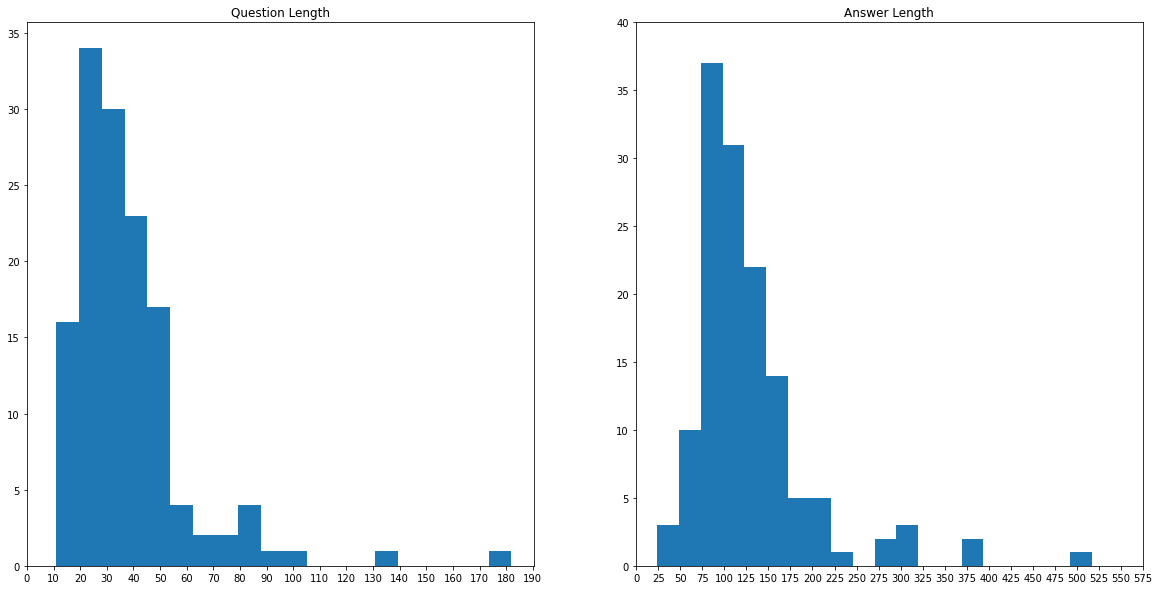

In [15]:
question_length = []
answer_length = []
for i in range(len(data1)):
    question_length.append(len(data1.loc[i, 'Question']))
    answer_length.append(len(data1.loc[i, 'Answer']))

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.hist(question_length, bins=20)
plt.xticks(ticks = range(0, 200, 10))
plt.yticks(ticks = range(0, 40, 5))
plt.title("Question Length")

plt.subplot(1, 2, 2)
plt.hist(answer_length, bins=20)
plt.xticks(ticks = range(0, 600, 25))
plt.yticks(ticks = range(0, 45, 5))
plt.title("Answer Length")

plt.show()

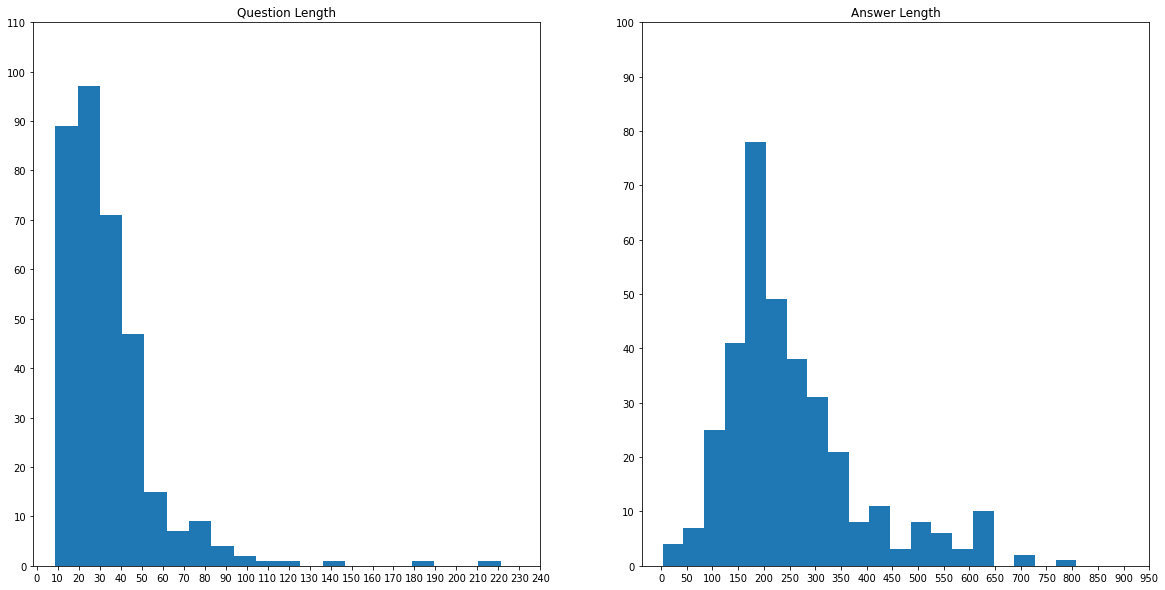

In [25]:
question_length = []
answer_length = []
for i in range(len(data234)):
    question_length.append(len(str(data234.loc[i, 'Question'])))
    answer_length.append(len(str(data234.loc[i, 'Answer'])))

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.hist(question_length, bins=20)
plt.xticks(ticks = range(0, 250, 10))
plt.yticks(ticks = range(0, 120, 10))
plt.title("Question Length")

plt.subplot(1, 2, 2)
plt.hist(answer_length, bins=20)
plt.xticks(ticks = range(0, 1000, 50))
plt.yticks(ticks = range(0, 110, 10))
plt.title("Answer Length")

plt.show()

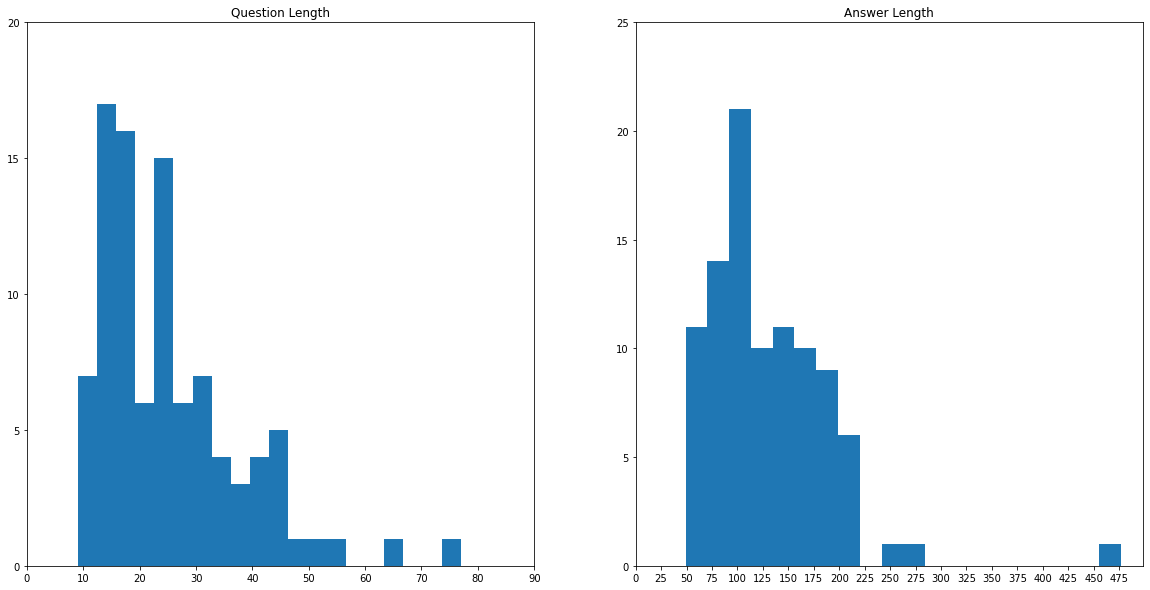

In [27]:
question_length = []
answer_length = []
for i in range(len(data5)):
    question_length.append(len(data5.loc[i, 'Question']))
    answer_length.append(len(data5.loc[i, 'Answer']))

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.hist(question_length, bins=20)
plt.xticks(ticks = range(0, 100, 10))
plt.yticks(ticks = range(0, 25, 5))
plt.title("Question Length")

plt.subplot(1, 2, 2)
plt.hist(answer_length, bins=20)
plt.xticks(ticks = range(0, 500, 25))
plt.yticks(ticks = range(0, 30, 5))
plt.title("Answer Length")

plt.show()

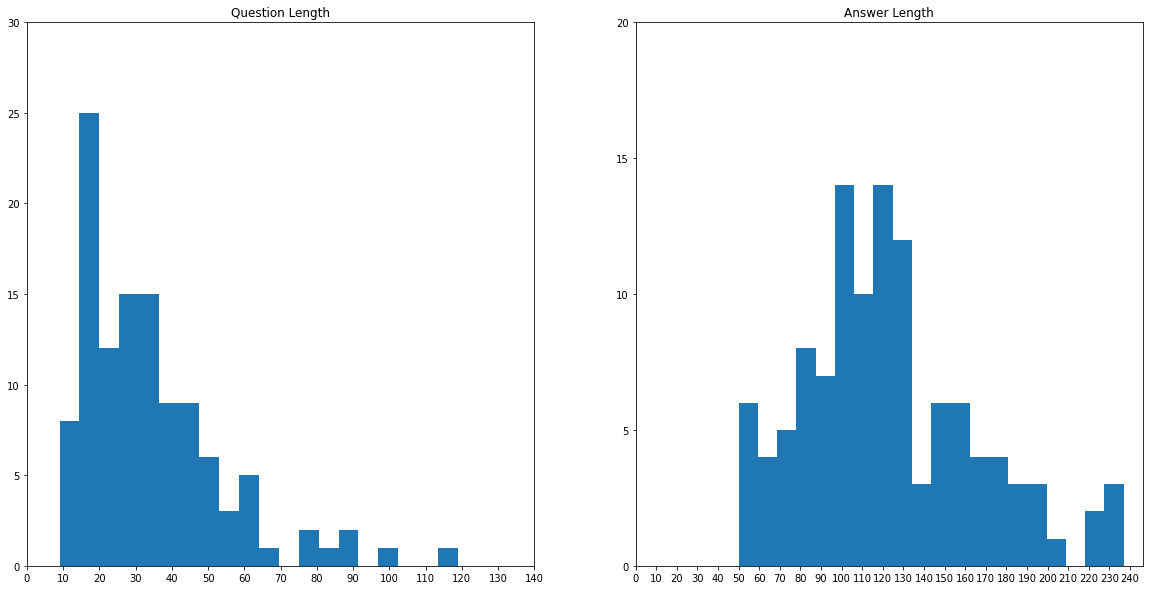

In [33]:
question_length = []
answer_length = []
for i in range(len(data6)):
    question_length.append(len(data6.loc[i, 'Question']))
    answer_length.append(len(data6.loc[i, 'Answer']))

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.hist(question_length, bins=20)
plt.xticks(ticks = range(0, 150, 10))
plt.yticks(ticks = range(0, 35, 5))
plt.title("Question Length")

plt.subplot(1, 2, 2)
plt.hist(answer_length, bins=20)
plt.xticks(ticks = range(0, 250, 10))
plt.yticks(ticks = range(0, 25, 5))
plt.title("Answer Length")

plt.show()

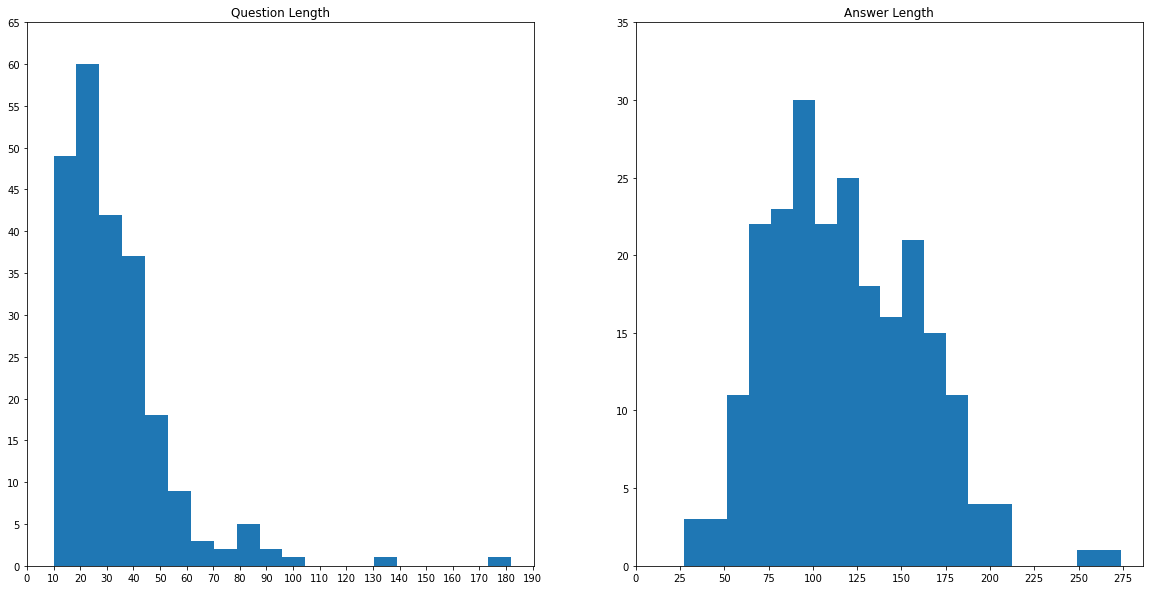

In [42]:
question_length = []
answer_length = []
for i in range(len(data78)):
    question_length.append(len(str(data78.loc[i, 'Question'])))
    answer_length.append(len(str(data78.loc[i, 'Answer'])))

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.hist(question_length, bins=20)
plt.xticks(ticks = range(0, 200, 10))
plt.yticks(ticks = range(0, 70, 5))
plt.title("Question Length")

plt.subplot(1, 2, 2)
plt.hist(answer_length, bins=20)
plt.xticks(ticks = range(0, 300, 25))
plt.yticks(ticks = range(0, 40, 5))
plt.title("Answer Length")

plt.show()

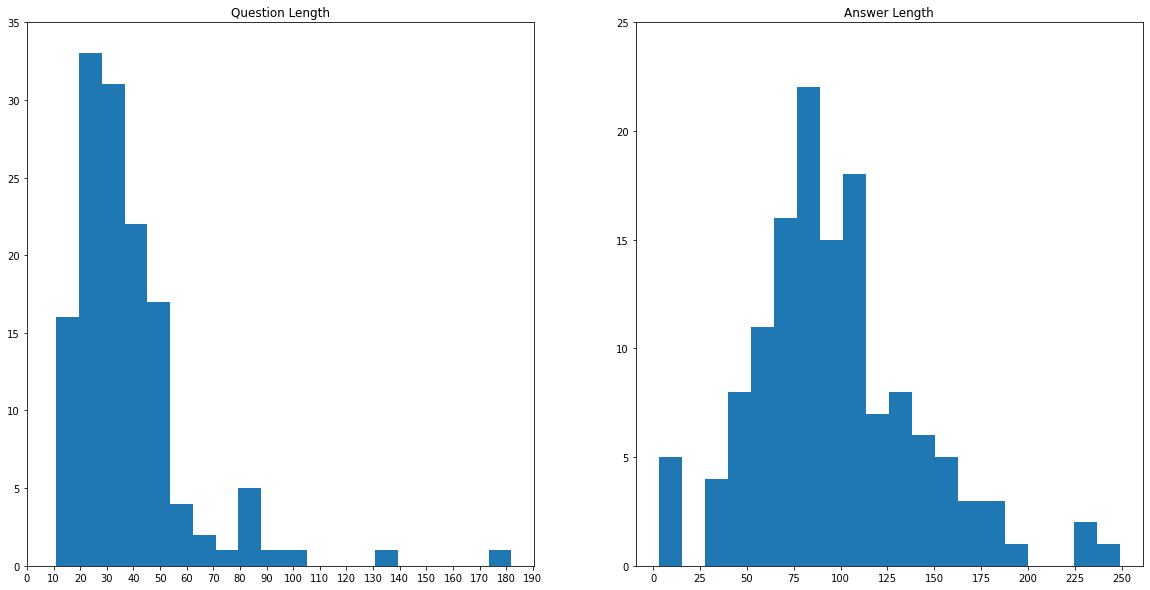

In [49]:
question_length = []
answer_length = []
for i in range(len(data9)):
    question_length.append(len(str(data9.loc[i, 'Question'])))
    answer_length.append(len(str(data9.loc[i, 'Answer'])))

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.hist(question_length, bins=20)
plt.xticks(ticks = range(0,200, 10))
plt.yticks(ticks = range(0, 40, 5))
plt.title("Question Length")

plt.subplot(1, 2, 2)
plt.hist(answer_length, bins=20)
plt.xticks(ticks = range(0, 275, 25))
plt.yticks(ticks = range(0, 30, 5))
plt.title("Answer Length")

plt.show()

### 2) 워드클라우드

#### (1) 질문

In [7]:
data234 = data234.dropna()

In [8]:
data9 = data9.dropna()

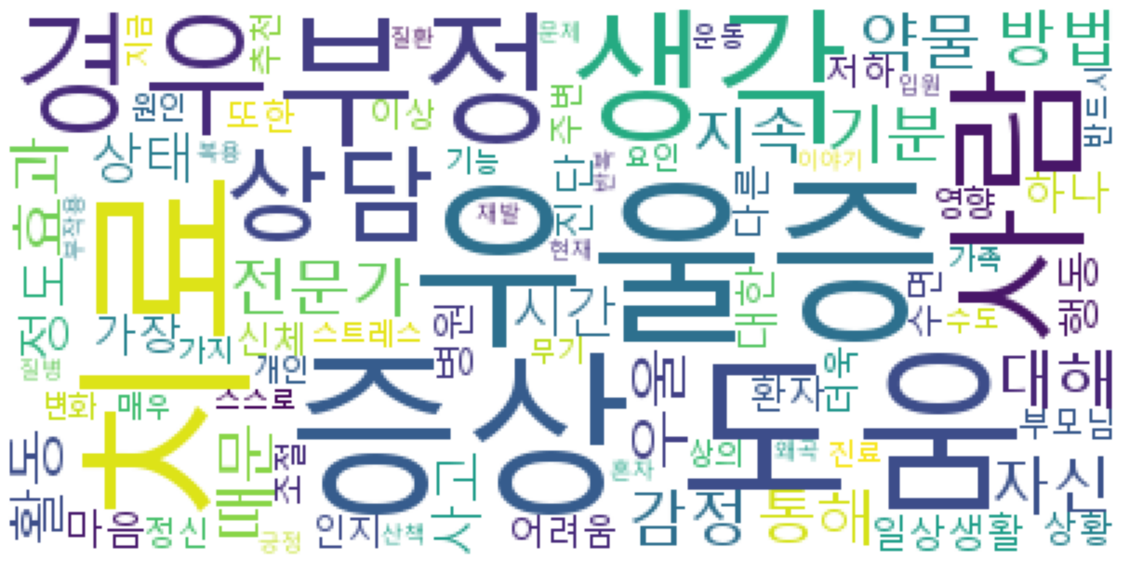

In [9]:
data_total = data1.append(data234).append(data5).append(data6).append(data78).append(data9)

data_total = str(data_total['Answer'].sum())
data_total = re.sub('^[ㄱ-ㅎㅏ-ㅣ가-힣a-zA-Z0-9\s]+', '', str(data_total))

data_noun = okt.nouns(data_total)
data_count = Counter(data_noun)

data_count_list = data_count.most_common(100)

data_word = []
for w in data_count_list:
    if (len(w[0]) > 1) and (w[1] > 1):
        data_word.append(w)

total_word = [i[0] for i in data_word]
cloud_str = " ".join(total_word)

wordcloud = WordCloud(font_path='C://Windows/Fonts/malgun.ttf', background_color='white').generate(cloud_str)
plt.figure(figsize=(20, 20))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()